# Podcast Listening Analysis Notebook

This notebook includes data loading, cleaning, preprocessing, analysis, and basic recommendation generation.

## Step 1: Load Data

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:

import pandas as pd
import json

# Load data
users = pd.read_csv('/content/drive/MyDrive/Thmania/users.csv')
episodes = pd.read_csv('/content/drive/MyDrive/Thmania/episodes.csv')
with open('/content/drive/MyDrive/Thmania/listens.json') as f:
    listens = pd.DataFrame(json.load(f))

# Preview raw data
users.head(), episodes.head(), listens.head()


(   user_id  age  gender       country
 0        1   38  female       Morocco
 1        2   30  female        Jordan
 2        3   42    male  Saudi Arabia
 3        4   57  female         Egypt
 4        5   51  female        Jordan,
    episode_id      title    category
 0           1  Episode 1    Religion
 1           2  Episode 2  Technology
 2           3  Episode 3     Society
 3           4  Episode 4        News
 4           5  Episode 5    Politics,
    user_id  episode_id  duration_seconds
 0       16          30                60
 1        6           8               120
 2        6          13                60
 3        6          27              1500
 4       17           9              1500)

## Step 2: Data Cleaning & Preprocessing

### Merge Datasets

In [61]:
df = listens.merge(users, on='user_id', how='left')
df = df.merge(episodes, on='episode_id', how='left')

### Check for Missing Values

In [62]:
df.isnull().sum()

,0
user_id,0
episode_id,0
duration_seconds,0
age,0
gender,0
country,0
title,0
category,0


### Remove Duplicates

In [63]:
df = df.drop_duplicates()

### Convert Data Types

In [64]:
# Convert to integers (IDs and durations)
df['user_id'] = df['user_id'].astype('int32')
df['episode_id'] = df['episode_id'].astype('int32')
df['duration_seconds'] = df['duration_seconds'].astype('int32')

# Convert to category (efficient for repeated string values)
df['gender'] = df['gender'].astype('category')
df['country'] = df['country'].astype('category')
df['category'] = df['category'].astype('category')

# Keep text columns as string (title is usually unique)
df['title'] = df['title'].astype(str)

### Handle Invalid Values (Check if Any Zeros  Exist (in All Columns))

In [65]:
# Get rows where any numeric column has a negative value
zero_rows = df[(df.select_dtypes(include='number') == 0).any(axis=1)]

print(f"Total rows with any zeros values: {len(zero_rows)}")
zero_rows

Total rows with any zeros values: 13


,user_id,episode_id,duration_seconds,age,gender,country,title,category
6,10,25,0,44,male,Jordan,Episode 25,Sports
10,14,13,0,19,female,Morocco,Episode 13,Society
12,17,6,0,21,male,Saudi Arabia,Episode 6,Society
21,5,15,0,51,female,Jordan,Episode 15,News
32,11,29,0,41,male,Morocco,Episode 29,Sports
33,2,19,0,30,female,Jordan,Episode 19,Politics
37,4,28,0,57,female,Egypt,Episode 28,News
40,20,22,0,32,female,Egypt,Episode 22,Society
55,18,10,0,52,male,Saudi Arabia,Episode 10,News
58,8,5,0,45,female,Jordan,Episode 5,Politics


### Handle Invalid Values (Check if Any Negative Values Exist (in All Columns))

In [66]:
# Get rows where any numeric column has a negative value
neg_rows = df[(df.select_dtypes(include='number') < 0).any(axis=1)]

print(f"Total rows with any negative values: {len(neg_rows)}")
neg_rows

Total rows with any negative values: 0


,user_id,episode_id,duration_seconds,age,gender,country,title,category


### Detect Outliers in All Numeric Columns (IQR Method)

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
'''
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

numeric_cols = df.select_dtypes(include='number').columns
columns_to_check = [col for col in numeric_cols if col not in ['user_id', 'episode_id']]

for col in columns_to_check:
    outliers, low, high = detect_outliers_iqr(df, col)
    print(f"\n Column: {col}")
    print(f"Lower Bound: {low}, Upper Bound: {high}")
    print(f"Total Outliers: {len(outliers)}")

    # Visualize
    plt.figure(figsize=(8, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
    plt.grid(True)
    plt.show()

'''
def detect_and_handle_outliers(data, column, non_negative=True):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Override if domain says no negatives allowed
    if non_negative and lower_bound < 0:
        lower_bound = 0

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    print(f"\n📊 Column: {column}")
    print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    print(f"Total Outliers Detected: {len(outliers)}")

    # Plot boxplot
    plt.figure(figsize=(8, 3))
    sns.boxplot(x=data[column])
    plt.title(f"Boxplot for {column}")
    plt.grid(True)
    plt.show()

    return outliers



📊 Column: duration_seconds
Lower Bound: 0, Upper Bound: 3660.0
Total Outliers Detected: 0


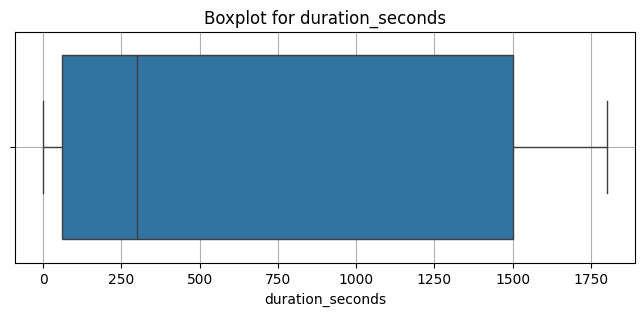


📊 Column: age
Lower Bound: 0, Upper Bound: 82.5
Total Outliers Detected: 0


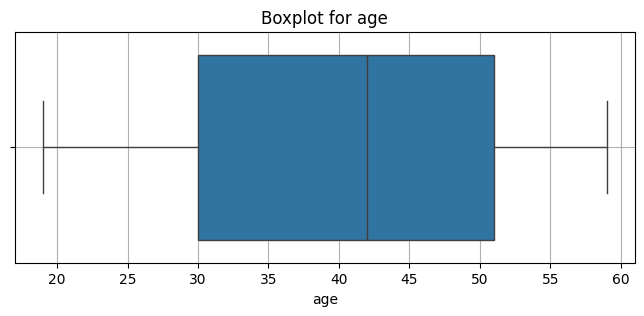

In [68]:
# Get numeric columns and remove ID fields
numeric_cols = df.select_dtypes(include='number').columns
features_to_check = [col for col in numeric_cols if col not in ['user_id', 'episode_id']]

# Run domain-aware outlier check
for feature in features_to_check:
    # Assume non-negative is True for all (customize as needed)
    detect_and_handle_outliers(df, feature, non_negative=True)

### Dataset Overview

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   user_id           100 non-null    int32   
 1   episode_id        100 non-null    int32   
 2   duration_seconds  100 non-null    int32   
 3   age               100 non-null    int64   
 4   gender            100 non-null    category
 5   country           100 non-null    category
 6   title             100 non-null    object  
 7   category          100 non-null    category
dtypes: category(3), int32(3), int64(1), object(1)
memory usage: 3.7+ KB


In [70]:
df.describe()

,user_id,episode_id,duration_seconds,age
count,100.000000,100.00000,100.000000,100.000000
mean,10.760000,15.50000,669.000000,39.760000
std,5.976587,9.64784,689.420046,11.849323
min,1.000000,1.00000,0.000000,19.000000
25%,6.000000,7.00000,60.000000,30.000000
50%,11.000000,14.00000,300.000000,42.000000
75%,16.000000,25.00000,1500.000000,51.000000
max,20.000000,30.00000,1800.000000,59.000000


### Feature correlations

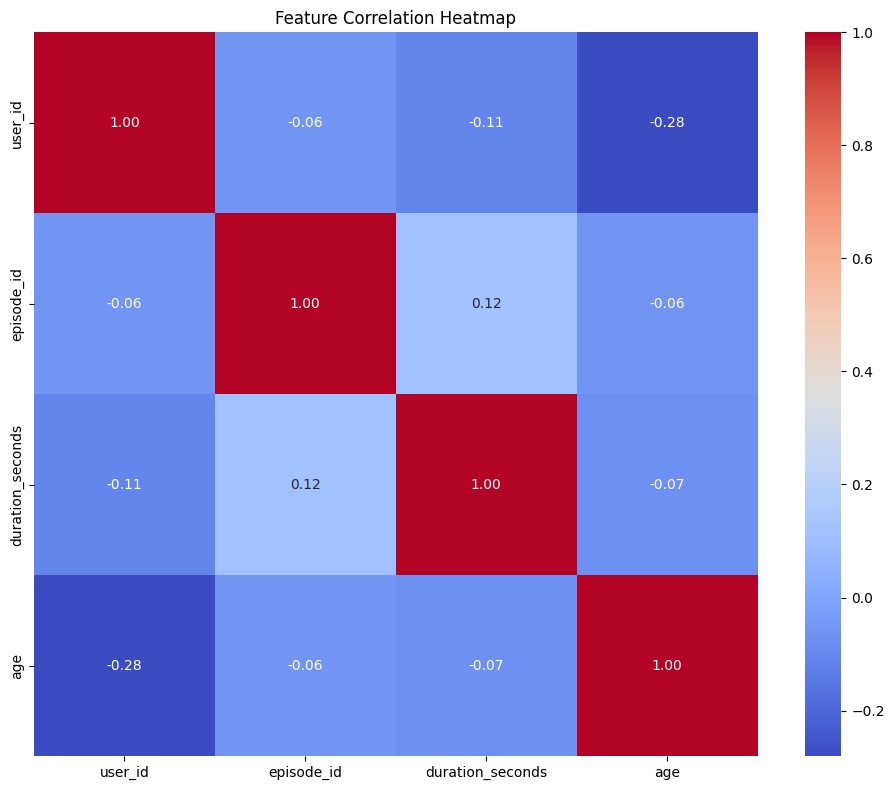

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Compute correlation matrix (only for numeric columns)
correlation_matrix = df.corr(numeric_only=True)

# 2. Plot heatmap
plt.figure(figsize=(10, 8))  # adjust size as needed
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)

plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

## Step 3A: Data Analysis

### 3.1 What are the most listened-to episode categories? ( أكثر فئات الحلقات استماعًا)

In [72]:
df_clean = df[df['duration_seconds'] > 0]
top_categories = df_clean.groupby('category')['duration_seconds'].sum().sort_values(ascending=False).reset_index()
top_categories

<ipython-input-72-f1fec039f74b>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_categories = df_clean.groupby('category')['duration_seconds'].sum().sort_values(ascending=False).reset_index()


,category,duration_seconds
0,Sports,23280
1,Society,18720
2,News,12300
3,Religion,5640
4,Technology,3900
5,Politics,3060


<ipython-input-73-3e542d09eda8>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='duration_hours', y='category', data=top_categories, palette='viridis')


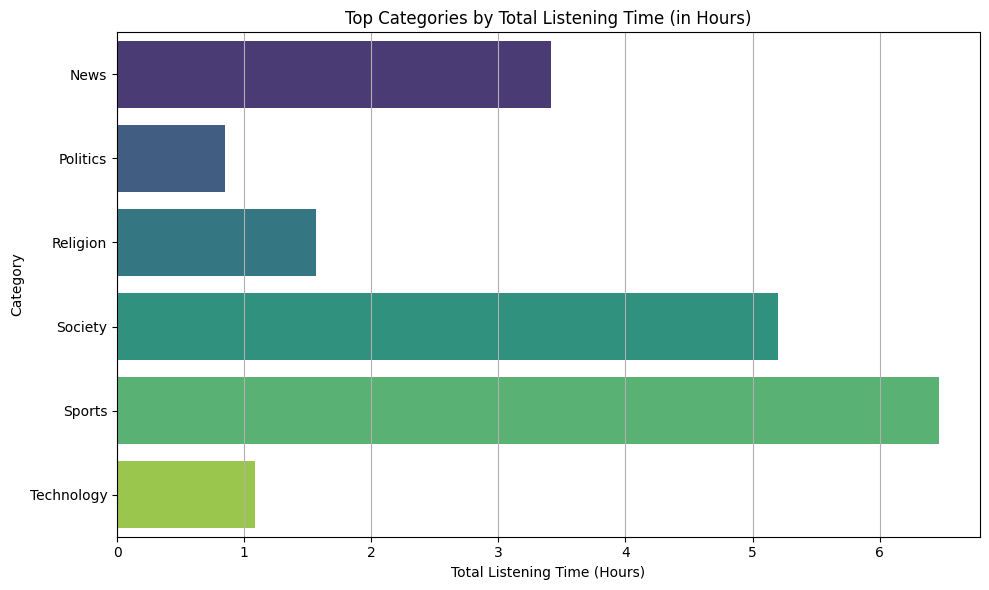

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert duration to hours for readability
top_categories['duration_hours'] = top_categories['duration_seconds'] / 3600

# Sort values again for plotting
top_categories = top_categories.sort_values('duration_hours', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='duration_hours', y='category', data=top_categories, palette='viridis')
plt.title("Top Categories by Total Listening Time (in Hours)")
plt.xlabel("Total Listening Time (Hours)")
plt.ylabel("Category")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

###  3.2 What is the difference in average listening duration between males and females? (الفرق في متوسط مدة الاستماع بين الذكور والإناث)

In [74]:
df_clean = df[df['duration_seconds'] > 0]

gender_avg_duration = df_clean.groupby('gender')['duration_seconds'].mean().reset_index()
gender_avg_duration

<ipython-input-74-0508b74f1e87>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_avg_duration = df_clean.groupby('gender')['duration_seconds'].mean().reset_index()


,gender,duration_seconds
0,female,908.181818
1,male,626.511628


Unique Users by Gender:
   gender  unique_user_count
0  female                 10
1    male                  9


<ipython-input-75-86d8f66aadfa>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_counts = df_clean.groupby('gender')['user_id'].nunique().reset_index(name='unique_user_count')
<ipython-input-75-86d8f66aadfa>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gender_counts, x='gender', y='unique_user_count', palette='viridis')


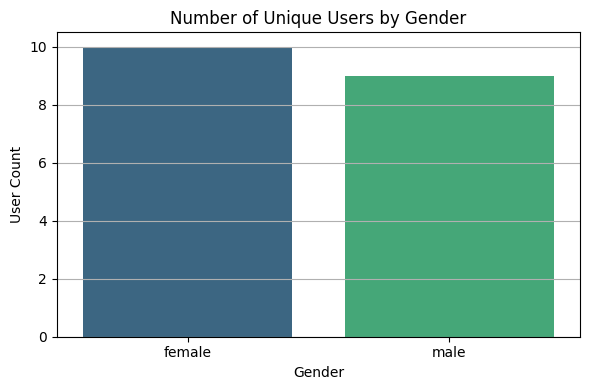

In [75]:
# First filter valid sessions
df_clean = df[df['duration_seconds'] > 0].copy()

# Count unique users by gender
gender_counts = df_clean.groupby('gender')['user_id'].nunique().reset_index(name='unique_user_count')
print("Unique Users by Gender:")
print(gender_counts)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.barplot(data=gender_counts, x='gender', y='unique_user_count', palette='viridis')
plt.title('Number of Unique Users by Gender')
plt.ylabel('User Count')
plt.xlabel('Gender')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

<ipython-input-76-422c09f6d4b0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gender', y='duration_minutes', data=gender_avg_duration, palette='viridis')


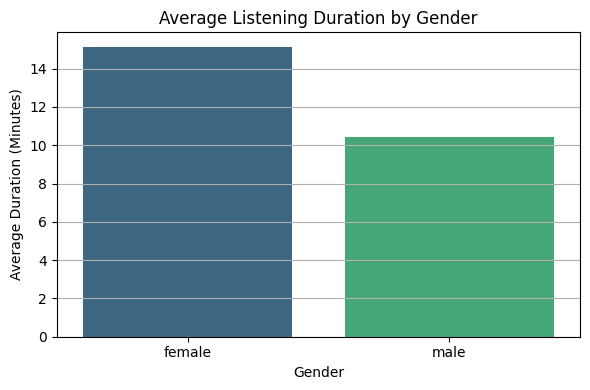

In [76]:
# Convert seconds to minutes for better readability. Since, most average sessions aren’t long enough for “hours”, so minutes are more relatable.
gender_avg_duration['duration_minutes'] = gender_avg_duration['duration_seconds'] / 60

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x='gender', y='duration_minutes', data=gender_avg_duration, palette='viridis')
plt.title("Average Listening Duration by Gender")
plt.ylabel("Average Duration (Minutes)")
plt.xlabel("Gender")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### 3.3 What is the average number of episodes listened to by a single user?
 متوسط عدد الحلقات التي استمع لها المستخدم الواحد (استبعاد الجلسات التي لم يحدث فيها استماع فعلي)

Average number of unique episodes per user: 4.42
Number of users by episode count:
episode_id
1    1
2    2
3    2
4    6
5    2
6    4
7    1
8    1
Name: count, dtype: int64


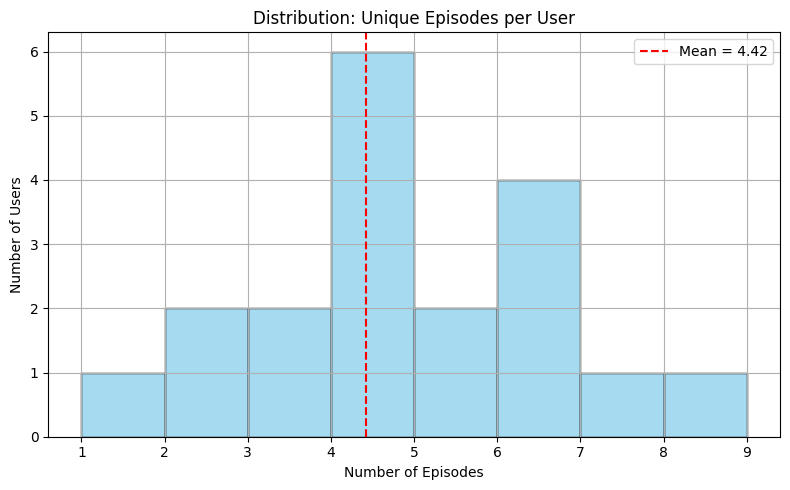

In [77]:
# 1. Calculate average number of unique episodes per user to measure actual listening activity:
df_clean = df[df['duration_seconds'] > 0]
episodes_per_user = df_clean.groupby('user_id')['episode_id'].nunique().mean()
print(f"Average number of unique episodes per user: {episodes_per_user:.2f}")

# 2. Distribution of unique episodes per user
episodes_per_user_dist = df_clean.groupby('user_id')['episode_id'].nunique()

# 3. Value counts (how many users fall into each episode count)
print("Number of users by episode count:")
print(episodes_per_user_dist.value_counts().sort_index())

# 4. Dynamic histogram range
min_val = episodes_per_user_dist.min()
max_val = episodes_per_user_dist.max()

# 5. Plot histogram with mean line
plt.figure(figsize=(8, 5))
sns.histplot(
    episodes_per_user_dist,
    bins=range(min_val, max_val + 2),  # +2 ensures last bin includes max
    color='skyblue'
)
plt.axvline(
    episodes_per_user_dist.mean(),
    color='red',
    linestyle='--',
    label=f'Mean = {episodes_per_user_dist.mean():.2f}'
)
plt.title("Distribution: Unique Episodes per User")
plt.xlabel("Number of Episodes")
plt.ylabel("Number of Users")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 3B: In-depth Behavioral Insight:
تحليل إضافي لفهم السلوك




### 3.4 Average Listening Duration Across Age Groups ( مدة الاستماع حسب العمر )

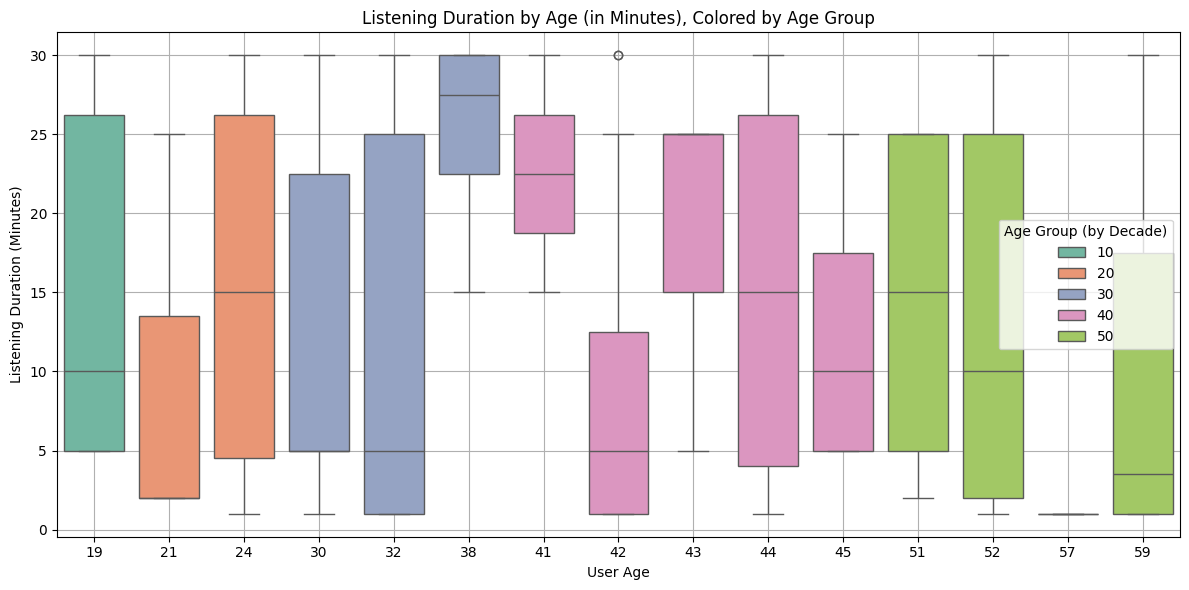

In [78]:
# 1. Filter out sessions with zero listening time
df_clean = df[df['duration_seconds'] > 0].copy()

# 2. Convert duration to minutes
df_clean["duration_minutes"] = df_clean["duration_seconds"] / 60

# 3. Create age group column by decade (e.g., 21 → 20s)
df_clean['age_group'] = (df_clean['age'] // 10) * 10

# 4. Plot: Boxplot of session duration by age, colored by age group
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='age',
    y='duration_minutes',
    hue='age_group',
    data=df_clean,
    palette='Set2'
)
plt.title("Listening Duration by Age (in Minutes), Colored by Age Group")
plt.xlabel("User Age")
plt.ylabel("Listening Duration (Minutes)")
plt.legend(title='Age Group (by Decade)')
plt.grid(True)
plt.tight_layout()
plt.show()

### 3.5 Gender-Based Podcast Category Preferences and Shared Interests:
Top categories preferred by each gender, and then determine the common favorite categories.

In [79]:
# Step 1: Clean data to exclude sessions with 0 duration
df_clean = df[df['duration_seconds'] > 0].copy()

# Step 2: Group by gender and category to get total listening duration
gender_category_stats = (
    df_clean.groupby(['gender', 'category'])['duration_seconds']
    .sum()
    .reset_index()
)

# Step 3: For each gender, get top 5 favorite categories
top_n = 5
top_categories_by_gender = (
    gender_category_stats.sort_values(['gender', 'duration_seconds'], ascending=[True, False])
    .groupby('gender')
    .head(top_n)
)

# Step 4: Get intersection (categories both genders have in their top 5)
male_top = set(top_categories_by_gender[top_categories_by_gender['gender'] == 'male']['category'])
female_top = set(top_categories_by_gender[top_categories_by_gender['gender'] == 'female']['category'])

common_top_categories = male_top.intersection(female_top)

print("Common Favorite Categories (Top 5 by Both Genders):")
for category in common_top_categories:
    print(f"• {category}")

Common Favorite Categories (Top 5 by Both Genders):
• Society
• Religion
• News
• Sports


<ipython-input-79-995bbb80aff3>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean.groupby(['gender', 'category'])['duration_seconds']
<ipython-input-79-995bbb80aff3>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('gender')


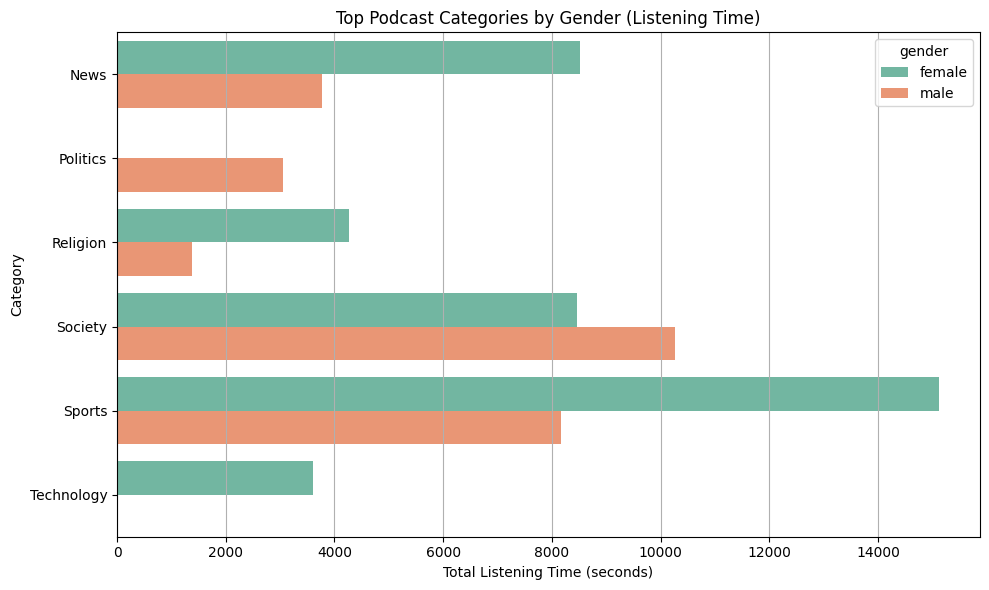

In [80]:
# Plot top categories by gender
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_categories_by_gender,
    x='duration_seconds',
    y='category',
    hue='gender',
    palette='Set2'
)
plt.title("Top Podcast Categories by Gender (Listening Time)")
plt.xlabel("Total Listening Time (seconds)")
plt.ylabel("Category")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

### 3.6 Episodes with High Repeat Listens based on age groups
Understanding listening habits by age group can inform **targeted content development**.



#### Which episodes are repeatedly listened to the most — broken down by age group.

In [81]:
# 1. Filter out zero-duration listens
df_clean = df[df['duration_seconds'] > 0].copy()

# 2. Create age group column by decade (e.g., 20s, 30s, etc.)
df_clean['age_group'] = (df_clean['age'] // 10) * 10

# 3. Count how many times each user listened to each episode
user_episode_counts = df_clean.groupby(['user_id', 'episode_id']).size().reset_index(name='listen_count')

# 4. Keep only those with repeated listens (more than once)
repeated = user_episode_counts[user_episode_counts['listen_count'] > 1]

# 5. Merge back age group info (from original df)
repeated = repeated.merge(df_clean[['user_id', 'age_group']].drop_duplicates(), on='user_id', how='left')

# 6. Count how many users in each age group re-listened to each episode
repeat_by_age_group = repeated.groupby(['episode_id', 'age_group'])['user_id'].nunique().reset_index(name='repeat_user_count')

# 7. Sort for top episodes per age group (example: top 5 per group)
top_repeats_by_age = repeat_by_age_group.sort_values(['age_group', 'repeat_user_count'], ascending=[True, False])

# Display
top_repeats_by_age.head(10)

,episode_id,age_group,repeat_user_count
2,9,20,1
0,1,40,1
1,3,40,1


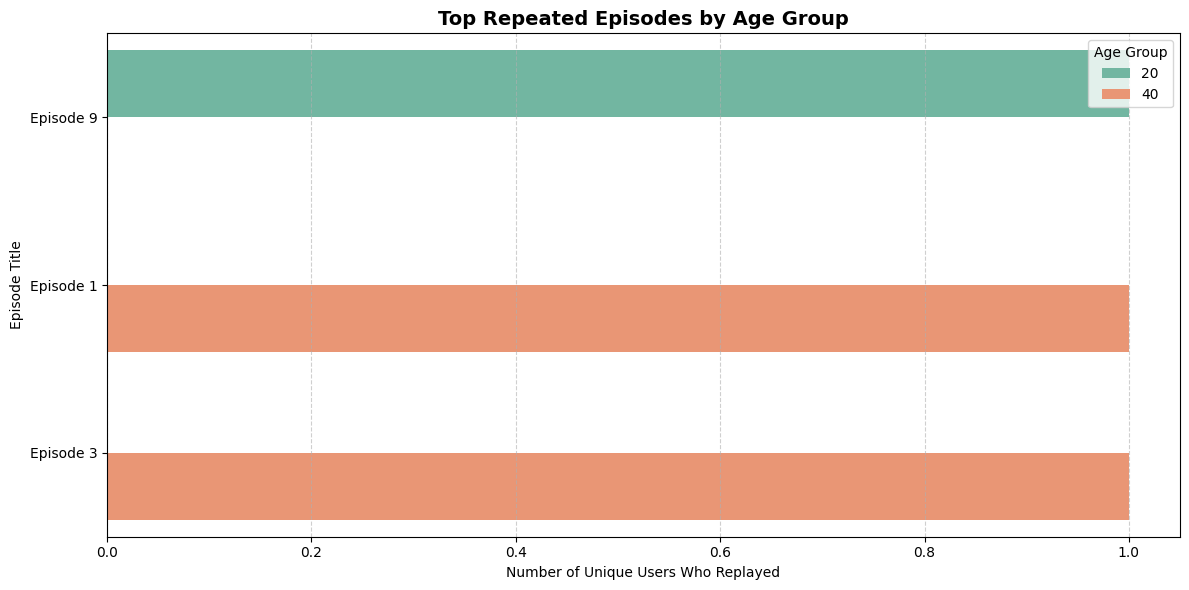

In [82]:
# Take top 5 episodes per age group
top_per_group = (
    top_repeats_by_age.groupby('age_group')
    .head(5)
    .sort_values(['age_group', 'repeat_user_count'], ascending=[True, False])
)

# Merge episode titles
top_per_group = top_per_group.merge(df[['episode_id', 'title']].drop_duplicates(), on='episode_id', how='left')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_per_group, x='repeat_user_count', y='title', hue='age_group', dodge=True, palette='Set2')
plt.title("Top Repeated Episodes by Age Group", fontsize=14, fontweight='bold')
plt.xlabel("Number of Unique Users Who Replayed")
plt.ylabel("Episode Title")
plt.legend(title="Age Group")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 3.7 Geo-Cultural Targeting (Country)
Analyze listening time across countries to guide **localization and market expansion strategies**.


In [83]:
df_clean = df[df['duration_seconds'] > 0].copy()
country_listening = (
    df_clean.groupby("country")["duration_seconds"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
country_listening

<ipython-input-83-e780e72c37ea>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean.groupby("country")["duration_seconds"]


,country,duration_seconds
0,Jordan,19620
1,Morocco,18900
2,Saudi Arabia,12120
3,Egypt,10200
4,UAE,6060


<ipython-input-84-fabc1c3933e3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_countries, x="duration_hours", y="country", palette="viridis")


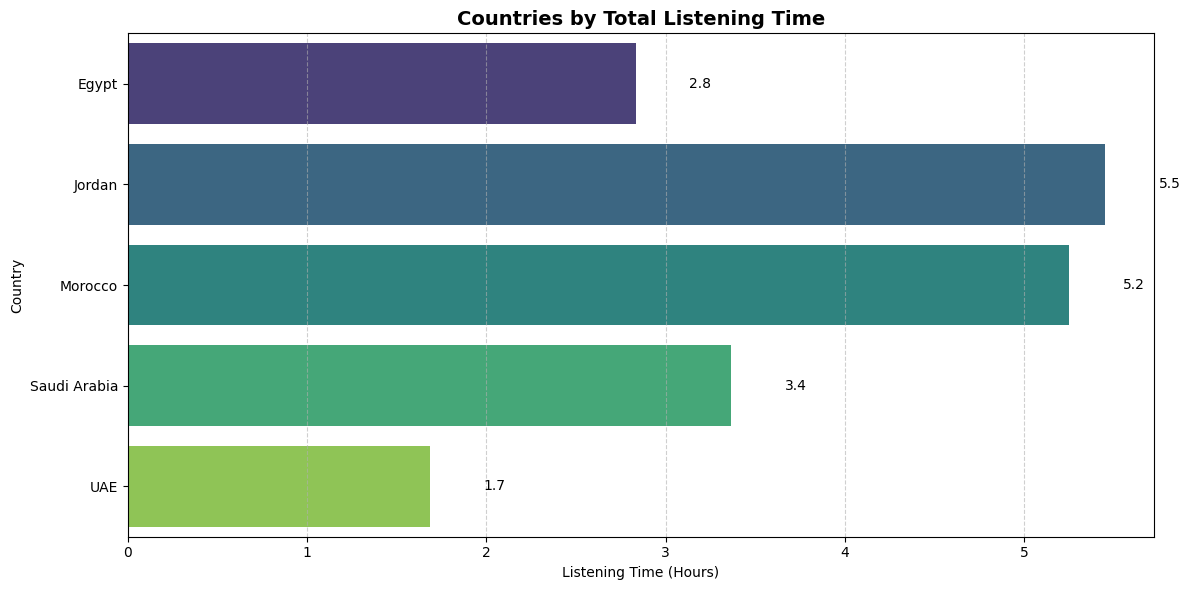

In [84]:
# Convert duration from seconds to hours
country_listening["duration_hours"] = country_listening["duration_seconds"] / 3600

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_countries, x="duration_hours", y="country", palette="viridis")
plt.title("Countries by Total Listening Time", fontsize=14, fontweight="bold")
plt.xlabel("Listening Time (Hours)")
plt.ylabel("Country")
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Add value labels
for p in plt.gca().patches:
    plt.text(p.get_width() + 0.3, p.get_y() + p.get_height() / 2, f"{p.get_width():.1f}", va="center")

plt.tight_layout()
plt.show()

### 3.8 Drop-off Detection (Short Sessions)
Sessions with **≤120 seconds duration** might indicate lack of interest or poor episode hook.

In [85]:
short_sessions = df[df["duration_seconds"] <= 120]
short_sessions

,user_id,episode_id,duration_seconds,age,gender,country,title,category
0,16,30,60,24,female,Saudi Arabia,Episode 30,Sports
1,6,8,120,59,male,Morocco,Episode 8,Sports
2,6,13,60,59,male,Morocco,Episode 13,Society
6,10,25,0,44,male,Jordan,Episode 25,Sports
7,15,6,60,42,male,UAE,Episode 6,Society
9,3,1,60,42,male,Saudi Arabia,Episode 1,Religion
10,14,13,0,19,female,Morocco,Episode 13,Society
11,12,24,120,52,female,Jordan,Episode 24,Society
12,17,6,0,21,male,Saudi Arabia,Episode 6,Society
20,19,12,60,42,male,Egypt,Episode 12,Sports


<ipython-input-86-3e263247111e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=short_sessions_by_country.head(10), x="count", y="country", palette="viridis")


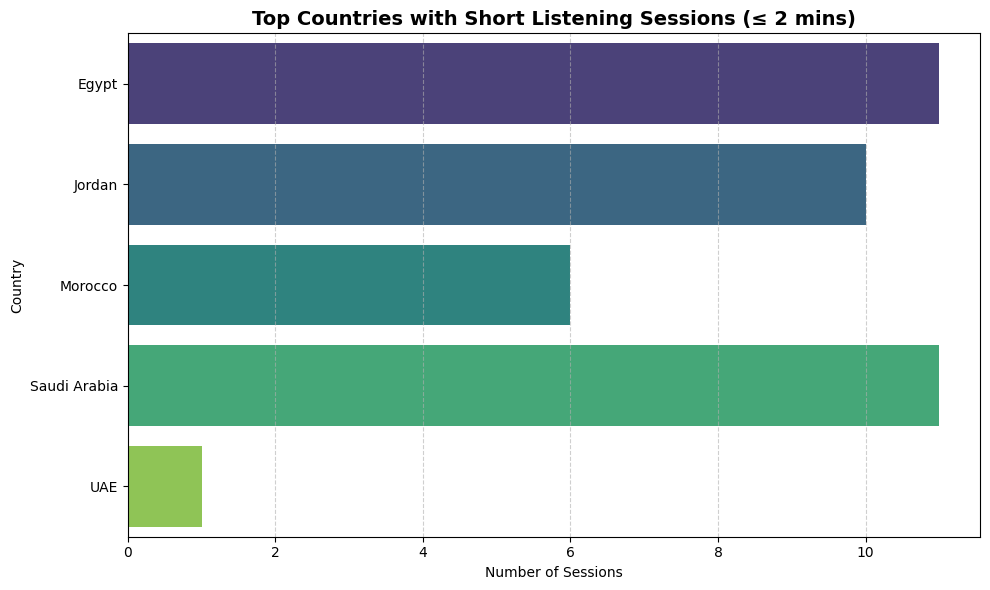

In [86]:
#Count of Short Sessions by Country
short_sessions_by_country = short_sessions["country"].value_counts().reset_index()
short_sessions_by_country.columns = ["country", "count"]
plt.figure(figsize=(10, 6))
sns.barplot(data=short_sessions_by_country.head(10), x="count", y="country", palette="viridis")
plt.title("Top Countries with Short Listening Sessions (≤ 2 mins)", fontsize=14, fontweight='bold')
plt.xlabel("Number of Sessions")
plt.ylabel("Country")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

####  Shows which gender tends to start and stop quickly more often, adjusted for how many users there are of each gender.

<ipython-input-87-a8fe59d734f6>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  short_sessions_by_gender = short_sessions.groupby("gender")["user_id"].count().reset_index(name="short_session_count")
<ipython-input-87-a8fe59d734f6>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_counts_by_gender = df_clean.groupby("gender")["user_id"].nunique().reset_index(name="user_count")
<ipython-input-87-a8fe59d734f6>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot

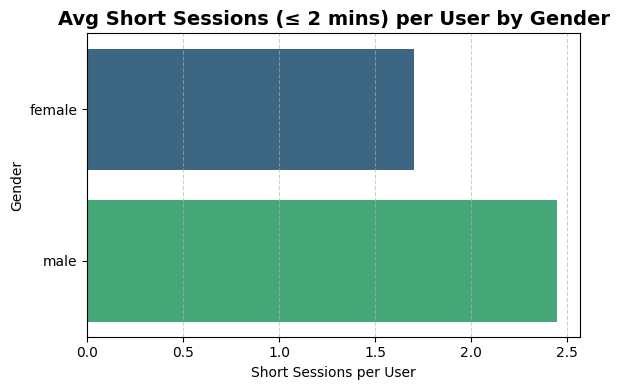

In [87]:
# Count of Short Sessions by Gender
# Step 1: Short sessions (already filtered)

# Step 2: Count short sessions by gender
short_sessions_by_gender = short_sessions.groupby("gender")["user_id"].count().reset_index(name="short_session_count")

# Step 3: Count unique users per gender
user_counts_by_gender = df_clean.groupby("gender")["user_id"].nunique().reset_index(name="user_count")

# Step 4: Merge both to compute rate
normalized = pd.merge(short_sessions_by_gender, user_counts_by_gender, on="gender")
normalized["short_sessions_per_user"] = normalized["short_session_count"] / normalized["user_count"]

# Step 5: Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(data=normalized, x="short_sessions_per_user", y="gender", palette="viridis")
plt.title("Avg Short Sessions (≤ 2 mins) per User by Gender", fontsize=14, fontweight='bold')
plt.xlabel("Short Sessions per User")
plt.ylabel("Gender")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### 3.9 Technical or UX Issues (Zero Duration)
Sessions with 0s duration might be due to **app bugs or accidental clicks**.


In [88]:
zero_duration_sessions = df[df["duration_seconds"] == 0]
zero_duration_sessions

,user_id,episode_id,duration_seconds,age,gender,country,title,category
6,10,25,0,44,male,Jordan,Episode 25,Sports
10,14,13,0,19,female,Morocco,Episode 13,Society
12,17,6,0,21,male,Saudi Arabia,Episode 6,Society
21,5,15,0,51,female,Jordan,Episode 15,News
32,11,29,0,41,male,Morocco,Episode 29,Sports
33,2,19,0,30,female,Jordan,Episode 19,Politics
37,4,28,0,57,female,Egypt,Episode 28,News
40,20,22,0,32,female,Egypt,Episode 22,Society
55,18,10,0,52,male,Saudi Arabia,Episode 10,News
58,8,5,0,45,female,Jordan,Episode 5,Politics


#### Zero-Duration Sessions

<ipython-input-89-f5450120fb7f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=zero_by_country.head(10), x="count", y="country", palette="viridis")


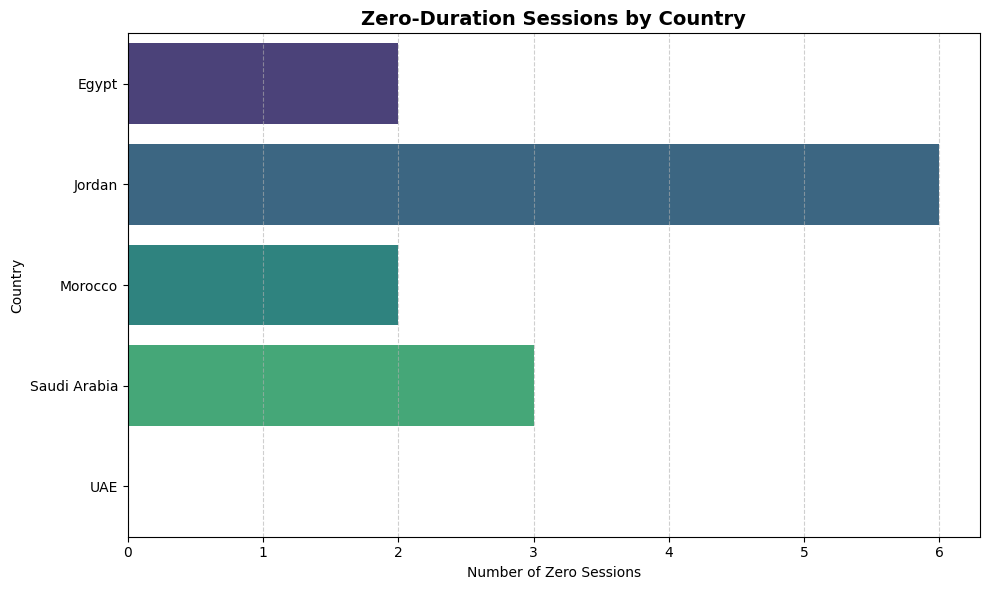

In [89]:
#Count of Zero-Duration Sessions by Country
zero_by_country = zero_duration_sessions["country"].value_counts().reset_index()
zero_by_country.columns = ["country", "count"]

plt.figure(figsize=(10, 6))
sns.barplot(data=zero_by_country.head(10), x="count", y="country", palette="viridis")
plt.title("Zero-Duration Sessions by Country", fontsize=14, fontweight='bold')
plt.xlabel("Number of Zero Sessions")
plt.ylabel("Country")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

<ipython-input-90-ffadb3d62dd8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=zero_duration_sessions, x="gender", palette="viridis")


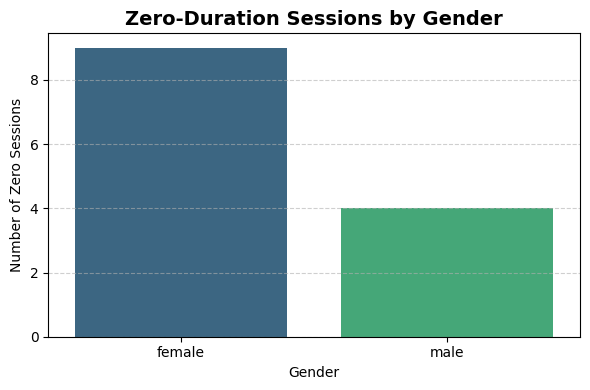

In [90]:
#Zero-Duration by Gender (Behavioral Insight)
plt.figure(figsize=(6, 4))
sns.countplot(data=zero_duration_sessions, x="gender", palette="viridis")
plt.title("Zero-Duration Sessions by Gender", fontsize=14, fontweight='bold')
plt.xlabel("Gender")
plt.ylabel("Number of Zero Sessions")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

<ipython-input-91-96832ca31c4d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_duration_sessions["age_group"] = (zero_duration_sessions["age"] // 10) * 10
<ipython-input-91-96832ca31c4d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=zero_duration_sessions, x="age_group", palette="viridis")


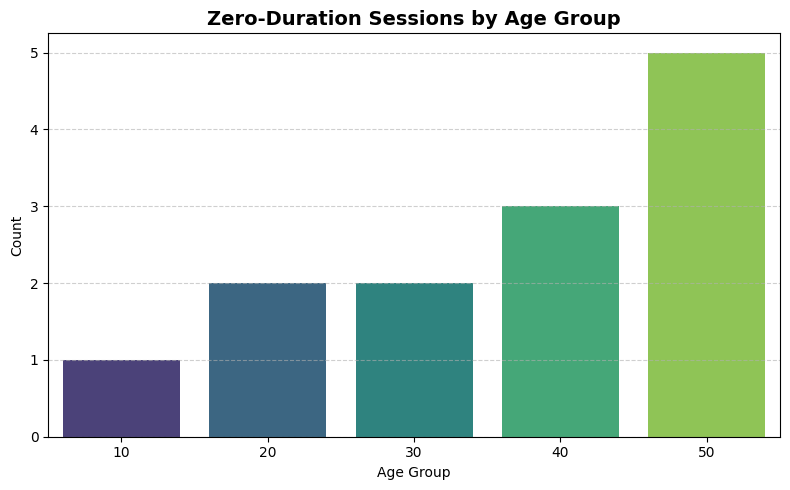

In [91]:
#Zero-Duration by Age Group (UX Improvement Insight)
zero_duration_sessions["age_group"] = (zero_duration_sessions["age"] // 10) * 10

plt.figure(figsize=(8, 5))
sns.countplot(data=zero_duration_sessions, x="age_group", palette="viridis")
plt.title("Zero-Duration Sessions by Age Group", fontsize=14, fontweight='bold')
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

##  Step 4: Basic Recommendations (3.10 )

In [92]:
def recommend_episodes(user_id, df_listens, df_episodes, top_n=3):
    # Step 1: Get user's top 2 categories
    user_data = df_listens[df_listens['user_id'] == user_id]
    top_categories = (
        user_data
        .groupby('category')['duration_seconds']
        .sum()
        .sort_values(ascending=False)
        .head(2)
        .index
    )

    # Step 2: Get episodes the user already listened to
    listened_episode_ids = user_data['episode_id'].unique()
    print(listened_episode_ids)

    # Step 3: Recommend from full episodes list, not just listens
    recommendations = (
        df_episodes[
            (df_episodes['category'].isin(top_categories)) &
            (~df_episodes['episode_id'].isin(listened_episode_ids))
        ]
        [['episode_id', 'title', 'category']]
        .drop_duplicates()
        .head(top_n)
    )

    return recommendations
recommend_episodes(user_id=5, df_listens=df_clean, df_episodes=episodes)

<ipython-input-92-fcc71d42a6b8>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('category')['duration_seconds']


[30 13 22 28 12]


,episode_id,title,category
2,3,Episode 3,Society
5,6,Episode 6,Society
7,8,Episode 8,Sports
